# 3dasm Project

## Agenda
## Single Fidelity
- simulated data and experimental data separately
- different kernels, optimizers
## Multi Fidelity
- scikit-learn vs gpytorch
1. [Phase 1: Gaussian Process on Simulated Data only](#Phase-1:-Gaussian-Process-on-Simulated-Data-only)
2. [Phase 1.5: Gaussian Process on Experimental Data Only](#Phase-1.5:-Gaussian-Process-on-Experimental-Data-Only)
3. [Phase 2: Multi-fidelity Gaussian Process](#Phase-2:-Multi-fidelity-Gaussian-Process)
4. [Phase 3: Multi-fidelity Gaussian Process](#Phase-3:-Multi-fidelity-Gaussian-Process)
5. [Phase 4: Error Metrics](#Phase-4:-Error-Metrics)

### Importing necessary packages

In [46]:
import matplotlib.pyplot as plt # import plotting tools to create figures
import numpy as np # import numpy to handle a lot of things!
from IPython.display import display, Math # to print with Latex math
import pandas as pd

%config InlineBackend.figure_format = "retina" # render higher resolution images in the notebook
plt.rcParams["figure.figsize"] = (8,4) # rescale figure size appropriately for slides

In [47]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, ExpSineSquared, ConstantKernel, WhiteKernel
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import make_scorer, r2_score, mean_squared_error

In [48]:
font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 12,
        } # using this property entry for nice plotting labels

<a id='Phase 1: Gaussian Process on Simulated Data only'></a>

## Phase 1: Gaussian Process on Simulated Data only

In [49]:
sim_df = pd.read_csv("../less_points_Simulation_Data_0.05_13900.csv") # read pandas DataFrame
print("Show the simulated DataFrameused for training data:\n", sim_df)

Show the simulated DataFrameused for training data:
             0         1
0    0.075682  0.995894
1    0.181336  0.977851
2    0.286990  0.944549
3    0.378912  0.901576
4    0.453920  0.855101
..        ...       ...
464  4.782890  0.157443
465  4.830016  0.156129
466  4.877141  0.154620
467  4.924266  0.153483
468  4.971392  0.153081

[469 rows x 2 columns]


In [50]:
Data_x_sim = sim_df.iloc[:,0] # select the input VALUES from your dataframe into Data_x
Data_y_sim = sim_df.iloc[:,1] # select the output VALUES from your dataframe inta Data_y
print("Data_x is:\n",Data_x_sim)
print("\nData_y is:\n",Data_y_sim)

Data_x is:
 0      0.075682
1      0.181336
2      0.286990
3      0.378912
4      0.453920
         ...   
464    4.782890
465    4.830016
466    4.877141
467    4.924266
468    4.971392
Name: 0, Length: 469, dtype: float64

Data_y is:
 0      0.995894
1      0.977851
2      0.944549
3      0.901576
4      0.855101
         ...   
464    0.157443
465    0.156129
466    0.154620
467    0.153483
468    0.153081
Name: 1, Length: 469, dtype: float64


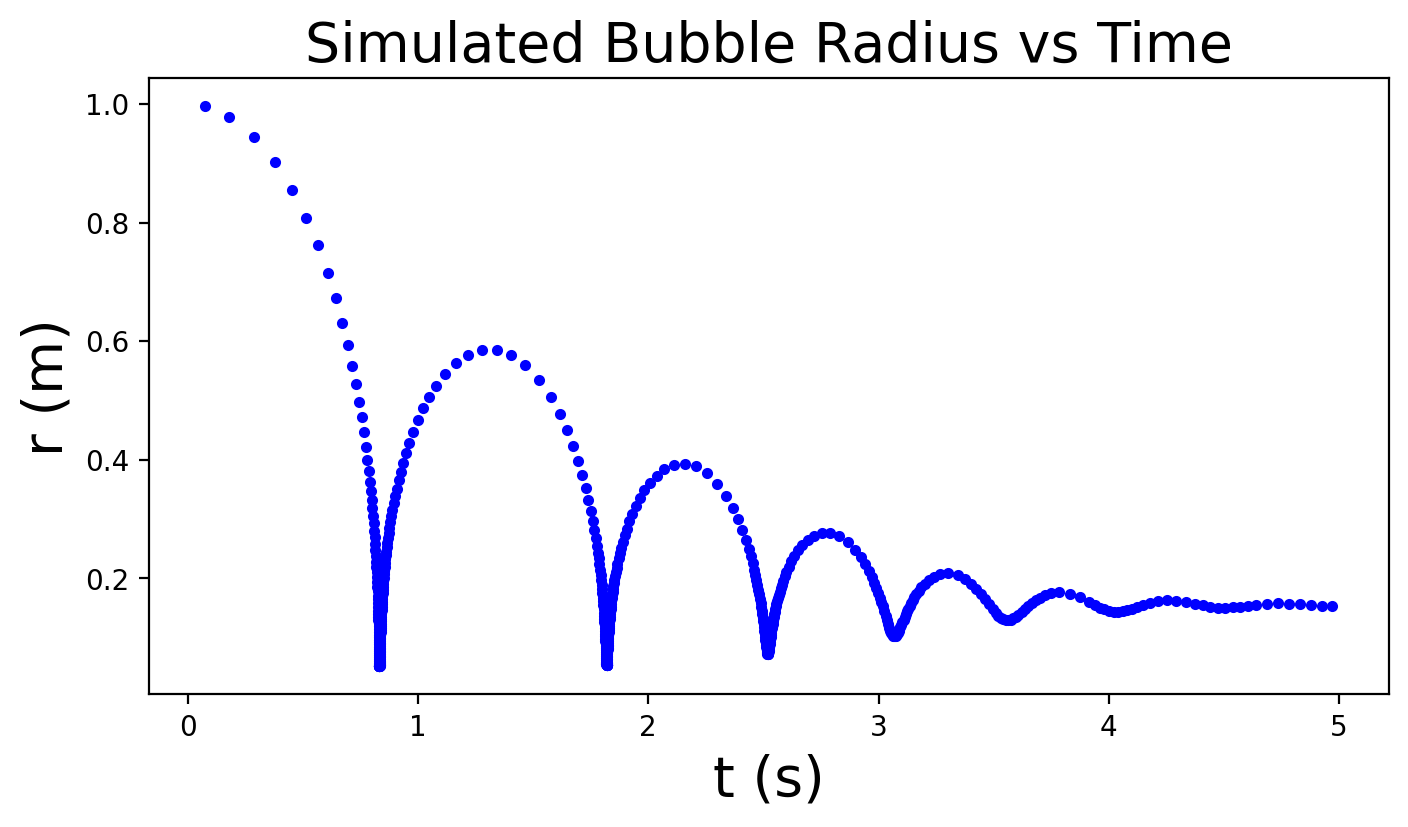

In [51]:
fig_sim_data, ax_sim_data = plt.subplots() # create a plot
ax_sim_data.plot(Data_x_sim, Data_y_sim, 'b.')
ax_sim_data.set_xlabel("t (s)", fontsize=20) # create x-axis label with font size 20
ax_sim_data.set_ylabel("r (m)", fontsize=20) # create y-axis label with font size 20
ax_sim_data.set_title("Simulated Bubble Radius vs Time", fontsize=20); # create title with font size 20
plt.show(fig_sim_data)

In [52]:
from sklearn.model_selection import train_test_split

n_data = 50 # number of points in our dataset
testset_ratio = 0.10 # ratio of test set points from the dataset

X_data_sim = np.reshape(Data_x_sim,(-1,1)) # a 2D array that scikit-learn likes

seed = 1987 # set a random seed so that everyone gets the same result
np.random.seed(seed)

# Let's split into 10% training points and the rest for testing:
X_train_sim, X_test_sim, y_train_sim, y_test_sim = train_test_split(X_data_sim,
                                    Data_y_sim, test_size=testset_ratio,
                                    random_state=seed)

x_train_sim = X_train_sim.ravel() # just for plotting later
x_test_sim = X_test_sim.ravel() # just for plotting later

In [53]:
# Define points used for plotting
n_max_sim = np.max(X_data_sim)
n_min_sim = np.min(X_data_sim)
n_plot = 500 # number of points used for plotting the model
x_plot_sim = np.linspace(n_min_sim, n_max_sim, n_plot) # create dataset with uniformly spaced points
X_plot_sim = np.reshape(x_plot_sim,(-1,1)) # a 2D array that scikit-learn likes

/oscar/home/mcarcana/3dasm_project/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


For Matern kernel, MSE = 0.0001,R^2 = 0.9982


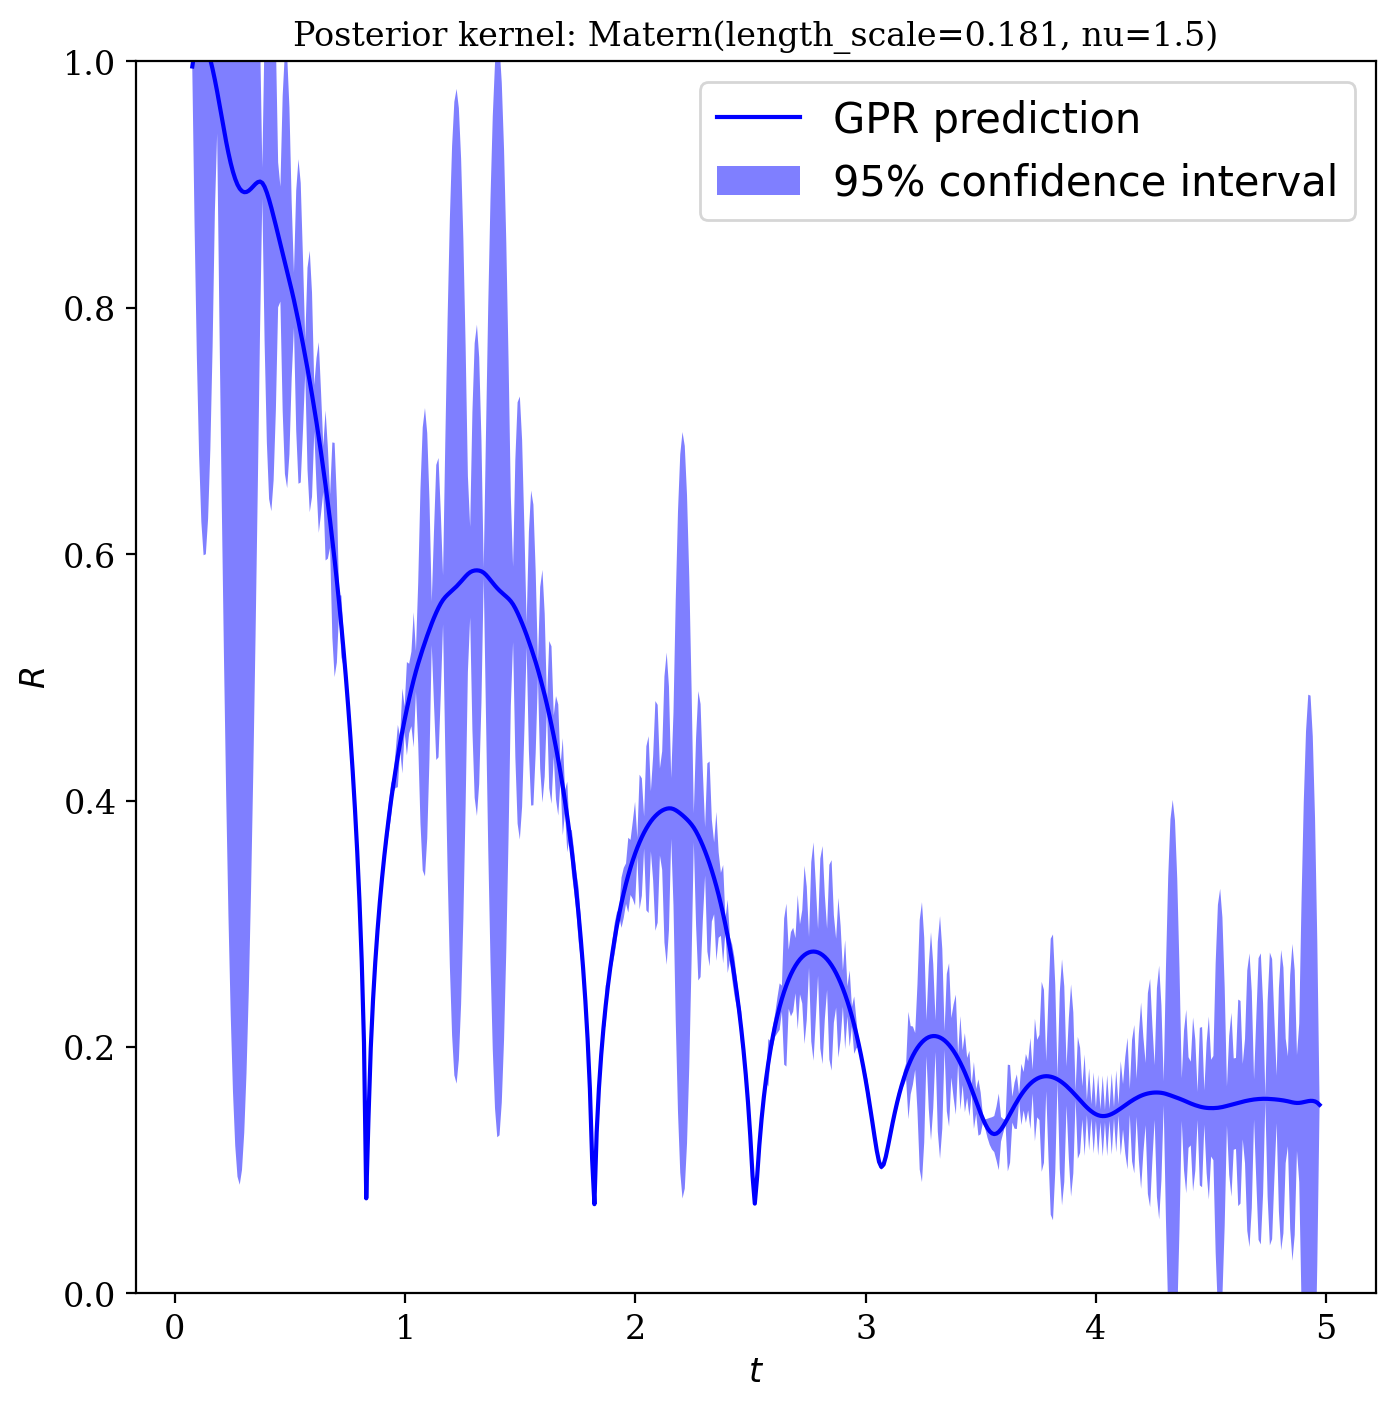

In [54]:
# Define the kernel function
kernel_M = Matern(length_scale=1.0, length_scale_bounds=(1e-2, 1e2),nu=1.5)

gp_model_sim = GaussianProcessRegressor(kernel=kernel_M, alpha=1e-6, optimizer='fmin_l_bfgs_b', n_restarts_optimizer=20)
#gp_model_sim = GaussianProcessRegressor(kernel=kernel_M, alpha=1e-6, optimizer='fmin_l_bfgs_b', n_restarts_optimizer=20) has MSE = 0.0001,R^2 = 0.9982

# Fit to data to determine parameters
gp_model_sim.fit(X_train_sim, y_train_sim)

# Make the prediction on the entire dataset (for plotting)
y_plot_pred_sim, sigma_plot_sim = gp_model_sim.predict(X_plot_sim, return_std=True) # also output the uncertainty (std)

# Predict for test set (for error metric)
y_pred_sim, sigma_sim = gp_model_sim.predict(X_test_sim, return_std=True) # also output the uncertainty (std)

# Extract error metrics
mse_M = mean_squared_error(y_test_sim,y_pred_sim)
r2_M = r2_score(y_test_sim,y_pred_sim)
print(f"For Matern kernel, MSE = {mse_M:.4f},R^2 = {r2_M:.4f}")

# Plot the prediction and the 95% confidence interval
fig1, ax1 = plt.subplots()

ax1.plot(x_plot_sim, y_plot_pred_sim, 'b-', label="GPR prediction")
ax1.fill(np.concatenate([x_plot_sim, x_plot_sim[::-1]]),
         np.concatenate([y_plot_pred_sim - 1.9600 * sigma_plot_sim,
                        (y_plot_pred_sim + 1.9600 * sigma_plot_sim)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')

ax1.set_xlabel('$t$', font)
ax1.set_ylabel('$R$', font)
plt.xticks(fontname = "serif", fontsize=12)
plt.yticks(fontname = "serif", fontsize=12)
ax1.set_title("Posterior kernel: %s"
              % gp_model_sim.kernel_, font) # Show in the title the value of the hyperparameters
ax1.legend(loc='upper right', fontsize=15)
ax1.set_ylim(0, 1) # just to provide more space for the legend
fig1.set_size_inches(8,8)
plt.savefig("sim_Matern_optimizer.png", bbox_inches="tight")
#plt.close(fig1) # close the plot to see it in next cell

<h id='Phase 1.5: Gaussian Process on Experimental Data Only'></h>

# Phase 1.5: Gaussian Process on Experimental Data Only

In [55]:
exp_df = pd.read_csv("../normalized_unscaled_Experimental_Data_10PA_.06BIS.csv") # read pandas DataFrame
print("Show the experimental DataFrame used for testing data:\n", exp_df)

Show the experimental DataFrame used for testing data:
      0.0170220398718178  0.999866408529248
0              0.044679           0.998759
1              0.072336           0.996847
2              0.099993           0.994077
3              0.127651           0.990380
4              0.155308           0.985505
..                  ...                ...
176            4.912334           0.163639
177            4.939991           0.159946
178            4.967648           0.156486
179            4.995306           0.154681
180            5.022963           0.155009

[181 rows x 2 columns]


In [56]:
Data_t_exp = exp_df.iloc[:,0]
Data_R_exp = exp_df.iloc[:,1] 
#Data_R2_exp = exp_df.iloc[:,2] 
print("Experimental x data is time:\n",Data_t_exp)
print("Experimental Bubble Radius is:\n",Data_R_exp)

Experimental x data is time:
 0      0.044679
1      0.072336
2      0.099993
3      0.127651
4      0.155308
         ...   
176    4.912334
177    4.939991
178    4.967648
179    4.995306
180    5.022963
Name: 0.0170220398718178, Length: 181, dtype: float64
Experimental Bubble Radius is:
 0      0.998759
1      0.996847
2      0.994077
3      0.990380
4      0.985505
         ...   
176    0.163639
177    0.159946
178    0.156486
179    0.154681
180    0.155009
Name: 0.999866408529248, Length: 181, dtype: float64


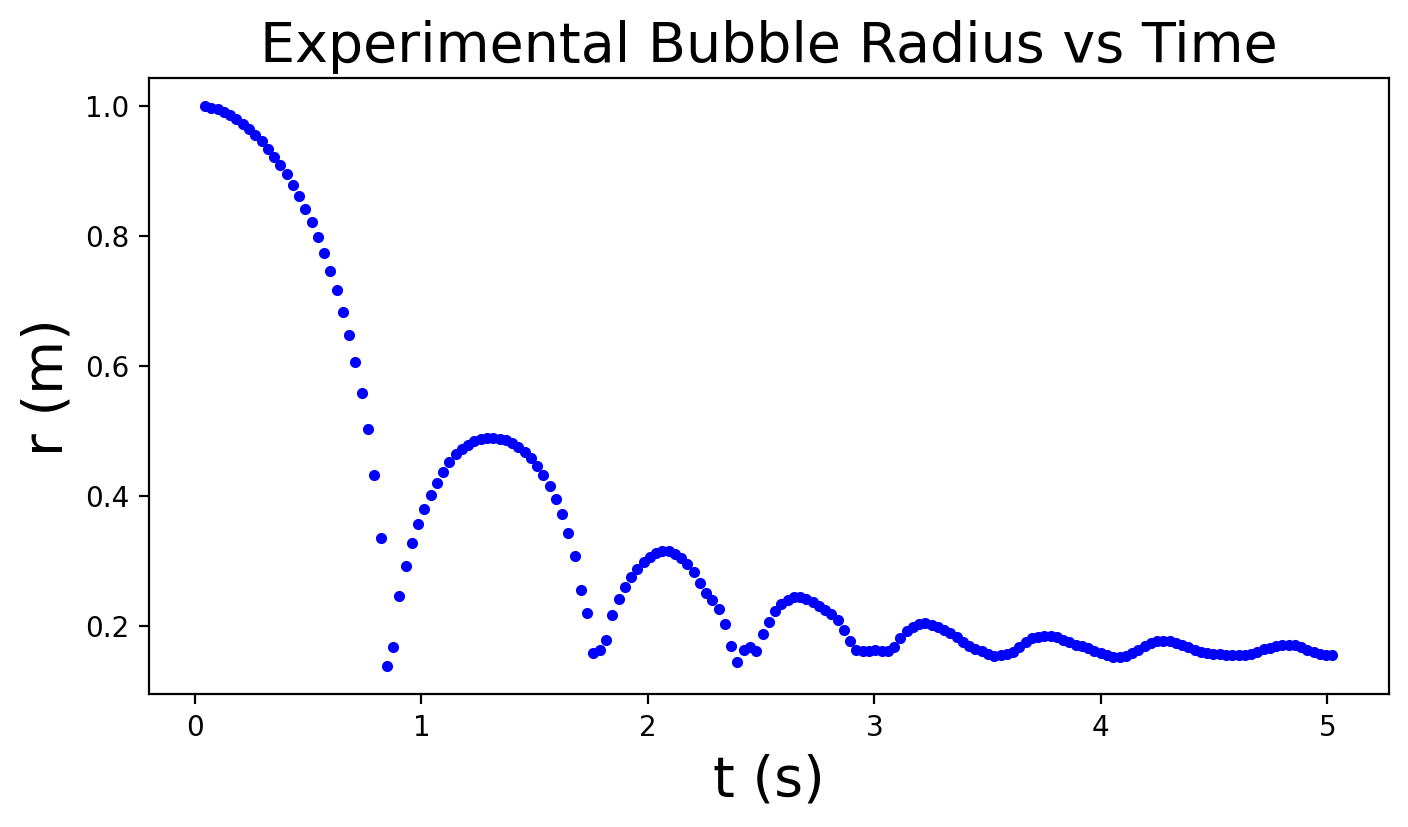

In [57]:
fig_exp_data, ax_exp_data = plt.subplots() # create a plot
ax_exp_data.plot(Data_t_exp, Data_R_exp, 'b.')
ax_exp_data.set_xlabel("t (s)", fontsize=20) # create x-axis label with font size 20
ax_exp_data.set_ylabel("r (m)", fontsize=20) # create y-axis label with font size 20
ax_exp_data.set_title("Experimental Bubble Radius vs Time", fontsize=20); # create title with font size 20
plt.show(fig_exp_data)

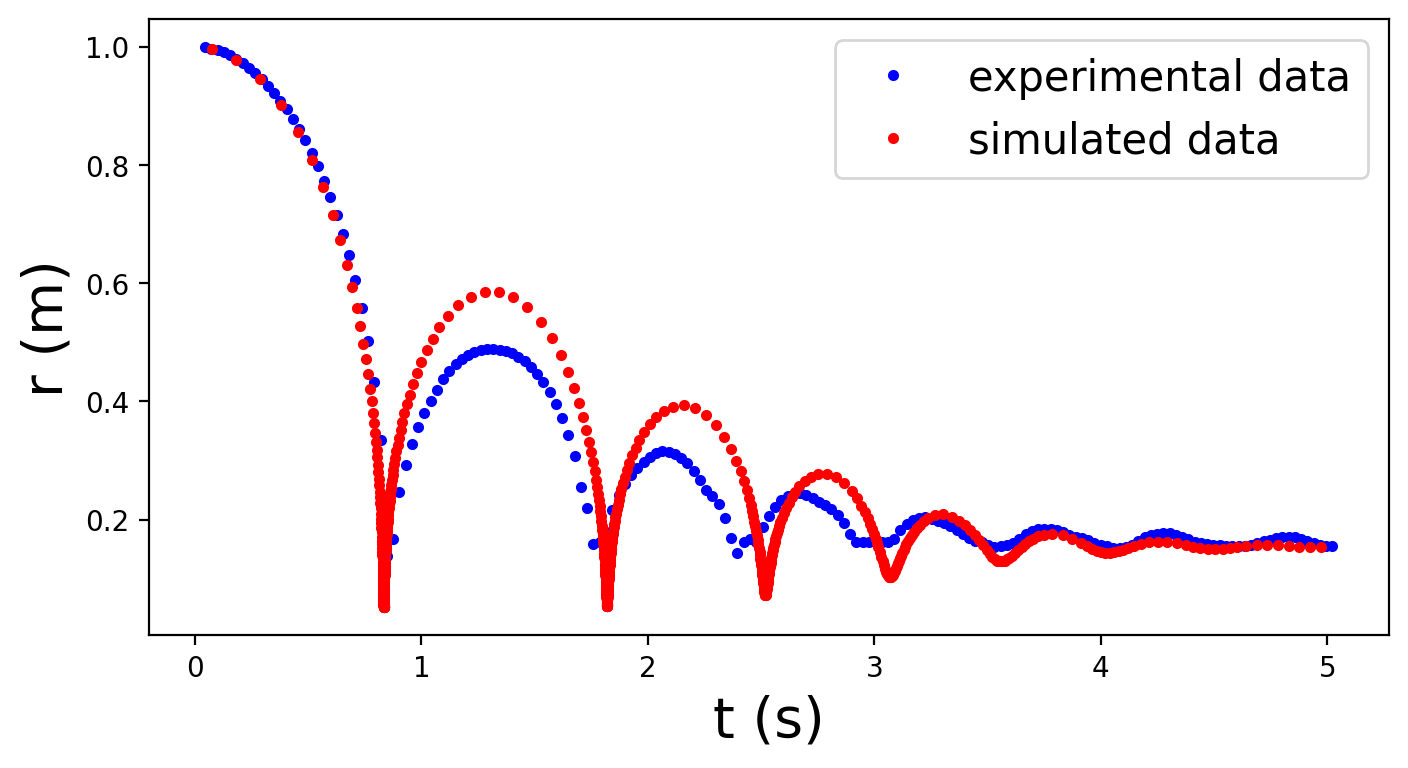

In [58]:

fig_data, ax_data = plt.subplots() # create a plot
ax_data.plot(Data_t_exp, Data_R_exp, 'b.',label="experimental data")
ax_data.plot(Data_x_sim, Data_y_sim, 'r.',label="simulated data")

ax_data.set_xlabel("t (s)", fontsize=20) # create x-axis label with font size 20

ax_data.set_ylabel("r (m)", fontsize=20) # create y-axis label with font size 20

#handles, labels = ax_data.get_legend_handles_labels()
#ax_data.legend(handles, labels)
ax_data.legend(loc='upper right', fontsize=15)
plt.show(fig_data)

In [59]:
n_data = len(Data_t_exp) # number of points in our dataset
testset_ratio = 0.75 # ratio of test set points from the dataset

t_data_exp = np.reshape(Data_t_exp,(-1,1)) # a 2D array that scikit-learn likes

seed = 1987 # set a random seed so that everyone gets the same result
np.random.seed(seed)

# Let's split into 10% training points and the rest for testing:
X_train_exp, X_test_exp, y_train_exp, y_test_exp = train_test_split(t_data_exp,
                                    Data_R_exp, test_size=testset_ratio,
                                    random_state=seed)

x_train_exp = X_train_exp.ravel() # just for plotting later
x_test_exp = X_test_exp.ravel() # just for plotting later

In [60]:
# Define points used for plotting
n_max_exp = np.max(t_data_exp)
n_min_exp = np.min(t_data_exp)
n_plot = 500 # number of points used for plotting the model
x_plot_exp = np.linspace(n_min_exp, n_max_exp, n_plot) # create dataset with uniformly spaced points
X_plot_exp = np.reshape(x_plot_exp,(-1,1)) # a 2D array that scikit-learn likes

For Matern kernel using experimental only data, MSE = 0.0006,R^2 = 0.9900


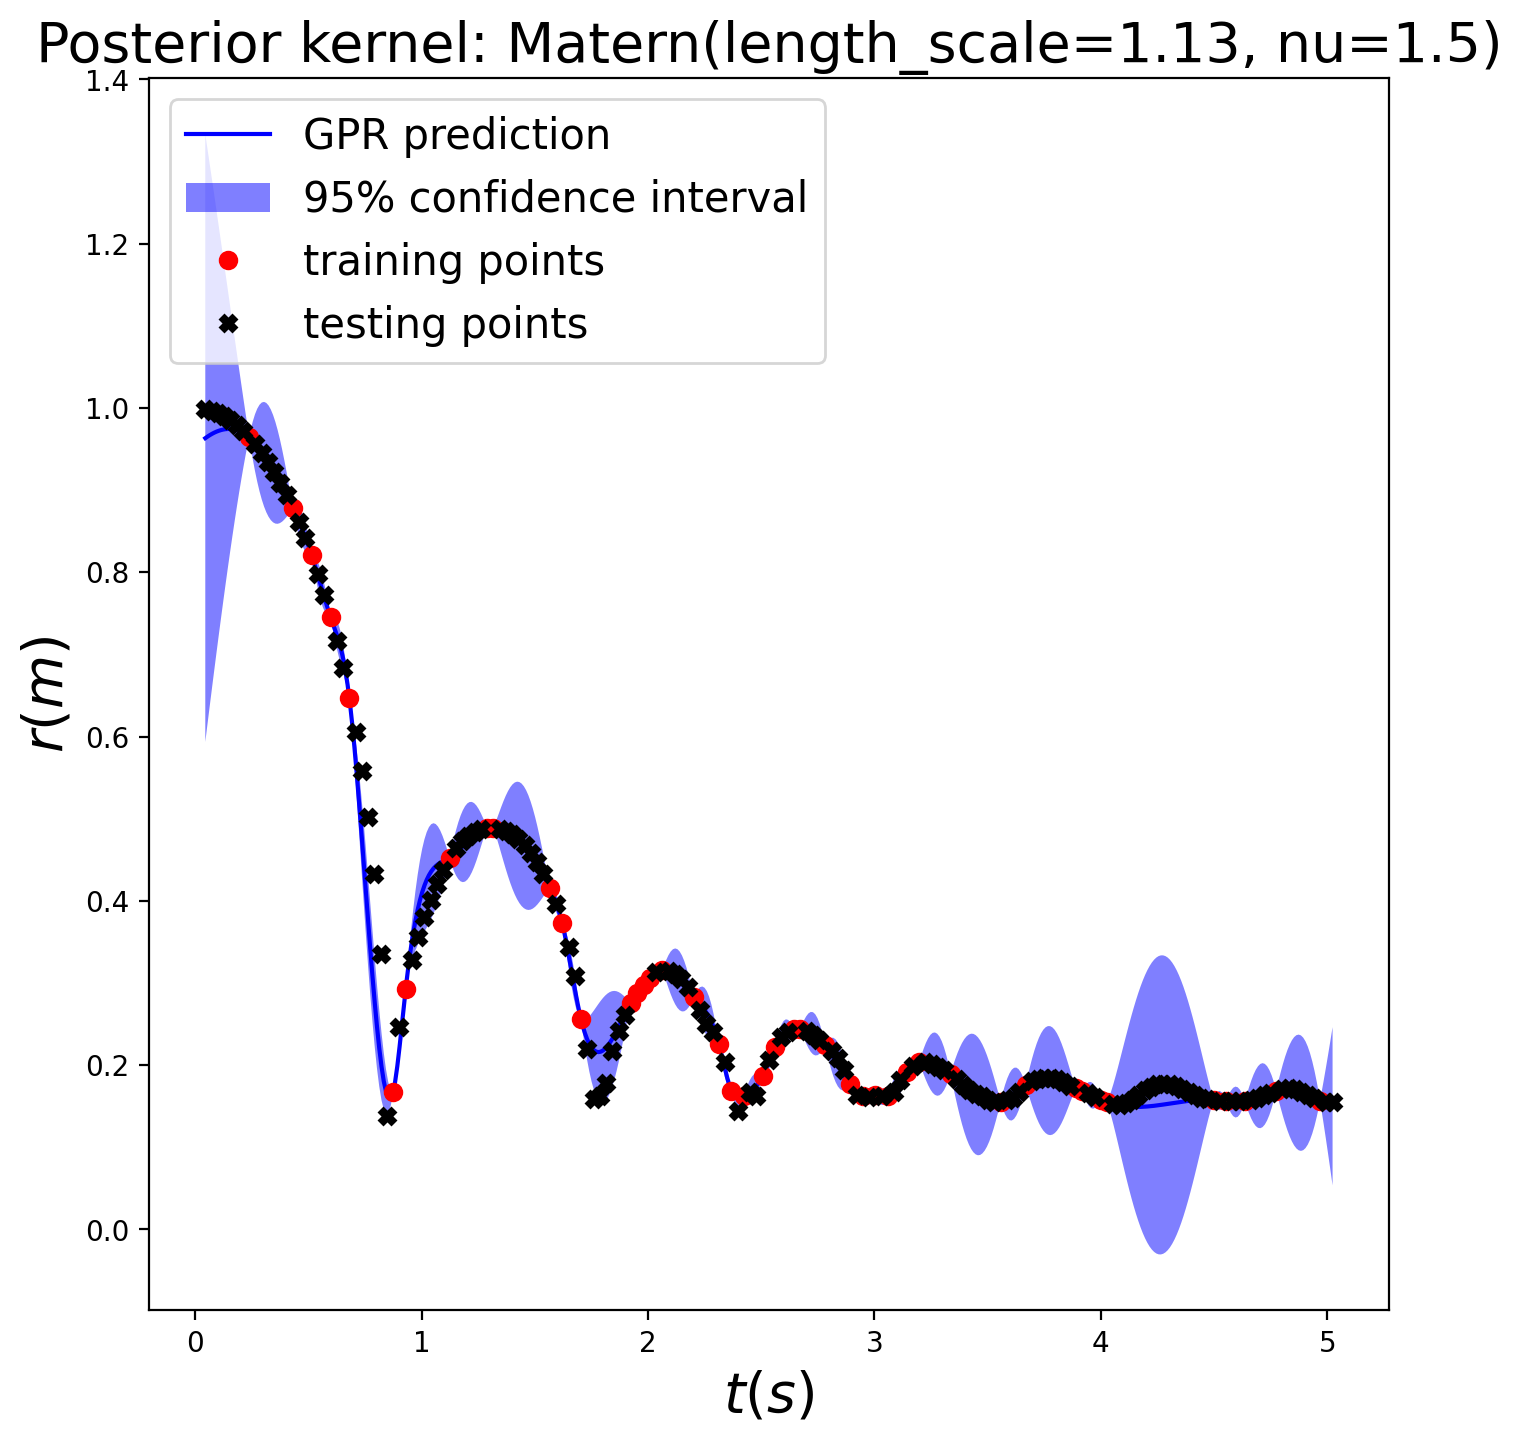

In [61]:
# Define the kernel function
HF_gp_model = GaussianProcessRegressor(kernel=kernel_M, alpha=1e-6, optimizer='fmin_l_bfgs_b', n_restarts_optimizer=20)
# HF_gp_model = GaussianProcessRegressor(kernel=kernel_M, alpha=1e-6, optimizer='fmin_l_bfgs_b', n_restarts_optimizer=20) has MSE = 0.0006,R^2 = 0.9900

# Fit to data to determine parameters
HF_gp_model.fit(X_train_exp, y_train_exp)

# Make the prediction on the entire dataset (for plotting)
y_plot_pred_exp, sigma_plot_exp = HF_gp_model.predict(X_plot_exp, return_std=True) # also output the uncertainty (std)

# Predict for test set (for error metric)
y_pred_exp, sigma_exp = HF_gp_model.predict(X_test_exp, return_std=True) # also output the uncertainty (std)

# Extract error metrics
mse_M = mean_squared_error(y_test_exp,y_pred_exp)
r2_M = r2_score(y_test_exp,y_pred_exp)
print(f"For Matern kernel using experimental only data, MSE = {mse_M:.4f},R^2 = {r2_M:.4f}")

# Plot the prediction and the 95% confidence interval
fig1, ax1 = plt.subplots()

ax1.plot(x_plot_exp, y_plot_pred_exp, 'b-', label="GPR prediction")
ax1.fill(np.concatenate([x_plot_exp, x_plot_exp[::-1]]),
         np.concatenate([y_plot_pred_exp - 1.9600 * sigma_plot_exp,
                        (y_plot_pred_exp + 1.9600 * sigma_plot_exp)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')

ax1.plot(x_train_exp, y_train_exp, 'ro', markersize=6, label="training points") # Plot train data
ax1.plot(x_test_exp, y_test_exp, 'kX', markersize=6, label="testing points") # Plot test points

ax1.set_xlabel('$t (s)$', fontsize=20)
ax1.set_ylabel('$r (m)$', fontsize=20)
ax1.set_title("Posterior kernel: %s"
              % HF_gp_model.kernel_, fontsize=20) # Show in the title the value of the hyperparameters
ax1.legend(loc='upper left', fontsize=15)
fig1.set_size_inches(8,8)

<c id='Phase 2: Multi-fidelity Gaussian Process'></c>

# Phase 2: Multi-fidelity Gaussian Process

In [89]:
# training data = (low fidelity) simulation data, test data = (high fidelity) experimental data

# defining training data
X_train_LF = X_data_sim # a 2D array that scikit-learn likes, for simulated data
y_train_LF = Data_y_sim

# defining test data
X_test_HF = t_data_exp
y_test_HF = Data_R_exp

n_data = len(Data_t_exp) # number of points in our dataset
#testset_ratio = len(X_train)/len(Data_t_exp) # ratio of test set points from the datasets

x_train_LF = X_train_LF.ravel() # just for plotting later
x_test_HF = X_test_HF.ravel() # just for plotting later

print(len(X_train_LF))
print(len(y_train_LF))

print(len(X_test_HF))
print(len(y_test_HF))

# Define points used for plotting
n_max_MF = np.max(X_train_LF)
n_min_MF = np.min(X_train_LF)
n_plot = 500 # number of points used for plotting the model
x_plot_MF = np.linspace(n_min_MF, n_max_MF, n_plot) # create dataset with uniformly spaced points
X_plot_MF = np.reshape(x_plot_MF,(-1,1)) # a 2D array that scikit-learn likes

469
469
181
181


In [90]:
# Setting up Training and Testing Data
train_x_LF = torch.Tensor(x_train_LF)
train_y_LF = torch.Tensor(y_train_LF)

X_test_HF = torch.Tensor(X_test_HF)
y_test_HF = torch.Tensor(y_test_HF)

# Stack the time tensor vertically to create a 2D tensor (column vector)
# The resulting tensor will have shape (num_points, 1)
input_tensor_LF = train_x_LF.view(-1, 1)

<c id='GPyTorch Regression for Single-task'></c>

# GPyTorch Regression for Single-task

In [91]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [92]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x_LF, train_y_LF, likelihood)

In [100]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

# Use the LBFGS optimizer
optimizer = torch.optim.LBFGS(model.parameters(), lr=0.1)

# Define the closure function for LBFGS optimization
def closure():
    optimizer.zero_grad()
    output = model(train_x_LF)
    loss = -mll(output, train_y_LF)
    loss.backward()
    return loss

# Run LBFGS optimization
for i in range(training_iter):
    optimizer.step(closure)
    
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, closure().item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))


Iter 1/50 - Loss: -1.992   lengthscale: 0.018   noise: 0.000
Iter 2/50 - Loss: -1.998   lengthscale: 0.019   noise: 0.000
Iter 3/50 - Loss: -2.005   lengthscale: 0.019   noise: 0.000
Iter 4/50 - Loss: -1.997   lengthscale: 0.019   noise: 0.000
Iter 5/50 - Loss: -2.001   lengthscale: 0.019   noise: 0.000
Iter 6/50 - Loss: -1.998   lengthscale: 0.019   noise: 0.000
Iter 7/50 - Loss: -1.998   lengthscale: 0.019   noise: 0.000
Iter 8/50 - Loss: -1.998   lengthscale: 0.019   noise: 0.000
Iter 9/50 - Loss: -1.998   lengthscale: 0.019   noise: 0.000
Iter 10/50 - Loss: -1.998   lengthscale: 0.019   noise: 0.000
Iter 11/50 - Loss: -1.998   lengthscale: 0.019   noise: 0.000
Iter 12/50 - Loss: -1.998   lengthscale: 0.019   noise: 0.000
Iter 13/50 - Loss: -1.998   lengthscale: 0.019   noise: 0.000
Iter 14/50 - Loss: -1.998   lengthscale: 0.019   noise: 0.000
Iter 15/50 - Loss: -1.998   lengthscale: 0.019   noise: 0.000
Iter 16/50 - Loss: -1.998   lengthscale: 0.019   noise: 0.000
Iter 17/50 - Loss

In [96]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

# Run Adam optimization
for i in range(training_iter):
    optimizer.zero_grad()
    output = model(train_x_LF)
    loss = -mll(output, train_y_LF)
    loss.backward()
    optimizer.step()
    
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))

Iter 1/50 - Loss: -0.609   lengthscale: 1.140   noise: 0.015
Iter 2/50 - Loss: -0.619   lengthscale: 1.074   noise: 0.016
Iter 3/50 - Loss: -0.625   lengthscale: 1.011   noise: 0.016
Iter 4/50 - Loss: -0.631   lengthscale: 0.950   noise: 0.016
Iter 5/50 - Loss: -0.639   lengthscale: 0.890   noise: 0.015
Iter 6/50 - Loss: -0.650   lengthscale: 0.833   noise: 0.014
Iter 7/50 - Loss: -0.663   lengthscale: 0.778   noise: 0.013
Iter 8/50 - Loss: -0.681   lengthscale: 0.726   noise: 0.013
Iter 9/50 - Loss: -0.704   lengthscale: 0.676   noise: 0.012
Iter 10/50 - Loss: -0.732   lengthscale: 0.629   noise: 0.011
Iter 11/50 - Loss: -0.771   lengthscale: 0.584   noise: 0.010
Iter 12/50 - Loss: -0.821   lengthscale: 0.541   noise: 0.010
Iter 13/50 - Loss: -0.876   lengthscale: 0.500   noise: 0.009
Iter 14/50 - Loss: -0.928   lengthscale: 0.460   noise: 0.008
Iter 15/50 - Loss: -0.971   lengthscale: 0.423   noise: 0.007
Iter 16/50 - Loss: -1.001   lengthscale: 0.390   noise: 0.007
Iter 17/50 - Loss

R^2: 0.72670068933879
MSE: 0.01623031497001648


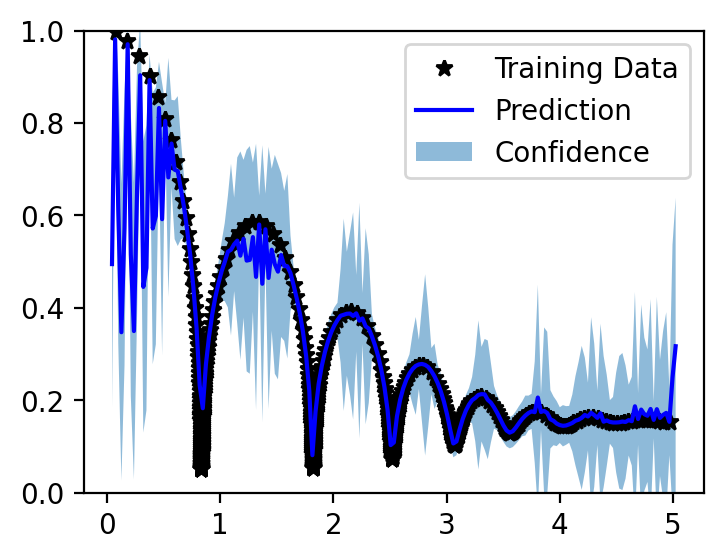

In [102]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(-1, 1, 51)
    observed_pred = likelihood(model(X_test_HF))

# Extract the mean and covariance of the predictions
mean_pred = observed_pred.mean.numpy()
covar_pred = observed_pred.covariance_matrix.numpy()

# Assuming you have ground truth test_y_LF as well
ground_truth = y_test_HF.numpy()

# Compute R^2 and MSE
r2 = r2_score(ground_truth, mean_pred)
mse = mean_squared_error(ground_truth, mean_pred)

# Save the metrics or use them as needed
#with open("metrics.txt", "w") as f:
#    f.write(f"R^2: {r2}\nMSE: {mse}")

# Print the metrics
print(f"R^2: {r2}")
print(f"MSE: {mse}")

with torch.no_grad(), gpytorch.settings.fast_pred_var():   
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x_LF.numpy(), train_y_LF.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(X_test_HF.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    #ax.fill_between(X_test_HF.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.fill_between(np.squeeze(X_test_HF.numpy()), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([0, 1.0])
    ax.legend(['Training Data', 'Prediction', 'Confidence'])

# Multi-fidelity, Multi-task

In [189]:
# Assuming X_train_sim, y_train_sim, X_test_exp, y_test_exp are defined
n_data = 50 # number of points in our dataset
seed = 1987 # set a random seed so that everyone gets the same result
np.random.seed(seed)

testset_ratio_sim = 0.7 # ratio of test set points from the dataset
# Let's split into 10% training points and the rest for testing:
X_train_sim, X_test_sim, y_train_sim, y_test_sim = train_test_split(X_data_sim,
                                    Data_y_sim, test_size=testset_ratio_sim,
                                    random_state=seed)

testset_ratio_exp = 0.19 # ratio of test set points from the dataset
# Let's split into 10% training points and the rest for testing:
X_train_exp, X_test_exp, y_train_exp, y_test_exp = train_test_split(t_data_exp,
                                    Data_R_exp, test_size=testset_ratio_exp,
                                    random_state=seed)

x_train_sim = X_train_sim.ravel() # just for plotting later
x_test_sim = X_test_sim.ravel() # just for plotting later
x_train_exp = X_train_exp.ravel() # just for plotting later
x_test_exp = X_test_exp.ravel() # just for plotting later

# print("Shape of X_train_sim:", X_train_sim.shape)
# print("Shape of X_train_exp:", X_train_exp.shape)
# # print("Shape of y_train_sim:", y_train_sim.shape)
# # print("Shape of y_train_exp:", y_train_exp.shape)

# # Since y_train_sim and y_train_exp are Pandas Series, must convert to numpy to reshape
# y_train_sim = y_train_sim.to_numpy().reshape(-1, 1)
# y_train_exp = y_train_exp.to_numpy().reshape(-1, 1)

# print("Shape of y_train_sim:", y_train_sim.shape)
# print("Shape of y_train_exp:", y_train_exp.shape)

# # Concatenate or stack the datasets along a new dimension
# #X_train_combined = torch.cat([torch.Tensor(X_train_sim), torch.Tensor(X_train_exp)], dim=0)
# #y_train_combined = torch.cat([torch.Tensor(y_train_sim), torch.Tensor(y_train_exp)], dim=0)

# X_train_combined = torch.vstack([torch.Tensor(X_train_sim), torch.Tensor(X_train_exp)])
# y_train_combined = torch.vstack([torch.Tensor(y_train_sim), torch.Tensor(y_train_exp)])


# # Convert Pandas Series to Numpy arrays without reshaping
# y_train_sim = y_train_sim.to_numpy()
# y_train_exp = y_train_exp.to_numpy()

# # Verify the shapes
# print("Shape of y_train_sim:", y_train_sim.shape)
# print("Shape of y_train_exp:", y_train_exp.shape)

# # Concatenate or stack the datasets along a new dimension
# X_train_combined = torch.vstack([torch.Tensor(X_train_sim), torch.Tensor(X_train_exp)])
# y_train_combined = torch.vstack([torch.Tensor(y_train_sim), torch.Tensor(y_train_exp)])

# # Verify the shapes after concatenation
# print("Shape of X_train_combined:", X_train_combined.shape)
# print("Shape of y_train_combined:", y_train_combined.shape)

y_train_sim = y_train_sim.to_numpy().reshape(-1, 1)
y_train_exp = y_train_exp.to_numpy().reshape(-1, 1)

X_train_combined = torch.vstack([torch.Tensor(X_train_sim), torch.Tensor(X_train_exp)])
y_train_combined = torch.vstack([torch.Tensor(y_train_sim), torch.Tensor(y_train_exp)])

# X_train_combined = torch.cat([torch.Tensor(X_train_sim), torch.Tensor(X_train_exp)], dim=0)
# y_train_combined = torch.cat([torch.Tensor(y_train_sim), torch.Tensor(y_train_exp)], dim=0)
# Verify the shapes after concatenation
print("Shape of X_train_combined:", X_train_combined.shape)
print("Shape of y_train_combined:", y_train_combined.shape)

Shape of X_train_combined: torch.Size([286, 1])
Shape of y_train_combined: torch.Size([286, 1])


In [190]:
# Assuming you have already defined the model and likelihood
# Update the likelihood to MultitaskGaussianLikelihood
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2)

# Update the model to handle multitask
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=2
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.MaternKernel(), num_tasks=2, rank=1
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

# Assuming X_train_combined, y_train_combined, and likelihood are defined
model = MultitaskGPModel(X_train_combined, y_train_combined, likelihood)

# Find optimal model hyperparameters
model.train()
likelihood.train()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

# Training loop
for i in range(training_iterations):
    optimizer.zero_grad()
    
    
    print("Shapes - X_train_combined:", X_train_combined.shape, "y_train_combined:", y_train_combined.shape)
    # Forward pass using X_train_combined
    output = model(X_train_combined)
    print("Output Shape:", output.mean.shape)

    
    loss = -mll(output, y_train_combined)
    loss.backward()
    optimizer.step()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))


Shapes - X_train_combined: torch.Size([286, 1]) y_train_combined: torch.Size([286, 1])
Output Shape: torch.Size([286, 2])


RuntimeError: The size of tensor a (286) must match the size of tensor b (572) at non-singleton dimension 0

In [162]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=2
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.MaternKernel(), num_tasks=2, rank=1
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

model = MultitaskGPModel(X_train_combined, y_train_combined, likelihood)

# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iterations = 2 if smoke_test else 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iterations):
    optimizer.zero_grad()

    print("Shapes - X_train_combined:", X_train_combined.shape, "y_train_combined:", y_train_combined.shape)

    # Forward pass using X_train_combined
    output = model(X_train_combined)

    print("Output Shape:", output.mean.shape)
    
    # Use y_train_combined for the loss calculation
    loss = -mll(output, y_train_combined)
    
    loss.backward()
    
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    optimizer.step()


Shapes - X_train_combined: torch.Size([286, 1]) y_train_combined: torch.Size([286, 1])
Output Shape: torch.Size([286, 2])


RuntimeError: The size of tensor a (286) must match the size of tensor b (572) at non-singleton dimension 0

In [191]:


# Assuming you have already defined the model and likelihood
# Update the likelihood to MultitaskGaussianLikelihood
likelihood_sim = gpytorch.likelihoods.GaussianLikelihood()
likelihood_exp = gpytorch.likelihoods.GaussianLikelihood()

# Assuming X_train_sim, y_train_sim, X_train_exp, y_train_exp are defined
# Also assuming X_train_combined, y_train_combined are defined as torch tensors

# Update the model to handle multitask
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.MaternKernel()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Create separate models for each task
model_sim = MultitaskGPModel(X_train_sim, y_train_sim, likelihood_sim)
model_exp = MultitaskGPModel(X_train_exp, y_train_exp, likelihood_exp)

# Find optimal model hyperparameters for each task
model_sim.train()
likelihood_sim.train()
optimizer_sim = torch.optim.Adam(model_sim.parameters(), lr=0.1)
mll_sim = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood_sim, model_sim)

model_exp.train()
likelihood_exp.train()
optimizer_exp = torch.optim.Adam(model_exp.parameters(), lr=0.1)
mll_exp = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood_exp, model_exp)

# Training loop for each task
for i in range(training_iterations):
    optimizer_sim.zero_grad()
    output_sim = model_sim(X_train_sim)
    loss_sim = -mll_sim(output_sim, y_train_sim)
    loss_sim.backward()
    optimizer_sim.step()
    print('Task: Simulated - Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss_sim.item()))

    optimizer_exp.zero_grad()
    output_exp = model_exp(X_train_exp)
    loss_exp = -mll_exp(output_exp, y_train_exp)
    loss_exp.backward()
    optimizer_exp.step()
    print('Task: Experimental - Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss_exp.item()))


RuntimeError: Train inputs must be a tensor, or a list/tuple of tensors

In [200]:
# Assuming you have already defined the model and likelihood
# Update the likelihood to MultitaskGaussianLikelihood
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2)

# Update the model to handle multitask
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=2
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.MaternKernel(), num_tasks=2, rank=1
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

# Find optimal model hyperparameters
model = MultitaskGPModel(X_train_combined, y_train_combined, likelihood)
model.train()
likelihood.train()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

# Training loop
for i in range(training_iterations):
    optimizer.zero_grad()
    
    # Forward pass using X_train_combined
    output = model(X_train_combined)
    
    # Create a mask for tasks with different sizes
    mask = torch.ones_like(y_train_combined, dtype=torch.uint8)
    mask[:len(y_train_sim)] = 0  # Set the mask for the simulated task to 0
    
    # Use boolean indexing to select only relevant predictions and targets
    output_masked = output.mean[mask.squeeze(-1), :]
    y_train_combined_masked = y_train_combined[mask].squeeze(-1)

    loss = -mll(output_masked, y_train_combined_masked)
    loss.backward()
    optimizer.step()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))


/tmp/ipykernel_82287/2634701657.py:40: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  output_masked = output.mean[mask.squeeze(-1), :]
/tmp/ipykernel_82287/2634701657.py:41: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  y_train_combined_masked = y_train_combined[mask].squeeze(-1)


RuntimeError: ExactMarginalLogLikelihood can only operate on Gaussian random variables

In [203]:
# Update the likelihood to MultitaskGaussianLikelihood
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2)

# Update the model to handle multitask
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=2
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.MaternKernel(), num_tasks=2, rank=1
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

# Find optimal model hyperparameters
model = MultitaskGPModel(X_train_combined, y_train_combined, likelihood)
model.train()
likelihood.train()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

# Training loop
for i in range(training_iterations):
    optimizer.zero_grad()
    
    # Forward pass using X_train_combined
    output = model(X_train_combined)
    
    # Create a mask for tasks with different sizes
    mask = torch.ones_like(y_train_combined, dtype=torch.uint8)
    mask[:len(y_train_sim)] = 0  # Set the mask for the simulated task to 0
    
    # Use cat to concatenate along the last dimension
    output_masked = torch.cat([output[..., 0][mask], output[..., 1][mask]], dim=-1)
    
    # Use gather to select the relevant targets
    y_train_combined_masked = y_train_combined.gather(dim=1, index=mask.nonzero(as_tuple=True)[0])
    
    loss = -mll(output_masked, y_train_combined_masked)
    loss.backward()
    optimizer.step()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))


RuntimeError: mean should be a matrix or a batch matrix (batch mode)

In [205]:
print("X_train_sim shape:", X_train_sim.shape)
print("y_train_sim shape:", y_train_sim.shape)
print("X_train_exp shape:", X_train_exp.shape)
print("y_train_exp shape:", y_train_exp.shape)

# Convert to torch tensors
X_train_sim = torch.Tensor(X_train_sim)
y_train_sim = torch.Tensor(y_train_sim)
X_train_exp = torch.Tensor(X_train_exp)
y_train_exp = torch.Tensor(y_train_exp)

print("X_train_sim shape after conversion:", X_train_sim.shape)
print("y_train_sim shape after conversion:", y_train_sim.shape)
print("X_train_exp shape after conversion:", X_train_exp.shape)
print("y_train_exp shape after conversion:", y_train_exp.shape)


# Update the likelihood to GaussianLikelihood
likelihood_sim = gpytorch.likelihoods.GaussianLikelihood()
likelihood_exp = gpytorch.likelihoods.GaussianLikelihood()

# Create separate models for each task
model_sim = MultitaskGPModel(X_train_sim, y_train_sim, likelihood_sim)
model_exp = MultitaskGPModel(X_train_exp, y_train_exp, likelihood_exp)

# Find optimal model hyperparameters for each task
model_sim.train()
likelihood_sim.train()
optimizer_sim = torch.optim.Adam(model_sim.parameters(), lr=0.1)
mll_sim = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood_sim, model_sim)

model_exp.train()
likelihood_exp.train()
optimizer_exp = torch.optim.Adam(model_exp.parameters(), lr=0.1)
mll_exp = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood_exp, model_exp)

# Training loop for each task
for i in range(training_iterations):
    optimizer_sim.zero_grad()
    output_sim = model_sim(X_train_sim)
    loss_sim = -mll_sim(output_sim, y_train_sim)
    loss_sim.backward()
    optimizer_sim.step()
    print('Task: Simulated - Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss_sim.item()))

    optimizer_exp.zero_grad()
    output_exp = model_exp(X_train_exp)
    loss_exp = -mll_exp(output_exp, y_train_exp)
    loss_exp.backward()
    optimizer_exp.step()
    print('Task: Experimental - Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss_exp.item()))


X_train_sim shape: torch.Size([140, 1])
y_train_sim shape: torch.Size([140, 1])
X_train_exp shape: torch.Size([146, 1])
y_train_exp shape: torch.Size([146, 1])
X_train_sim shape after conversion: torch.Size([140, 1])
y_train_sim shape after conversion: torch.Size([140, 1])
X_train_exp shape after conversion: torch.Size([146, 1])
y_train_exp shape after conversion: torch.Size([146, 1])


RuntimeError: Shape mismatch: objects cannot be broadcast to a single shape

### scikit-learn

In [146]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.base import BaseEstimator, RegressorMixin

class MultiTaskGaussianProcess(BaseEstimator, RegressorMixin):
    def __init__(self, regressors):
        self.regressors = regressors

    def fit(self, X, y, sample_weight=None):
        for regressor, target in zip(self.regressors, y.T):
            regressor.fit(X, target, sample_weight=sample_weight)

    def predict(self, X):
        return [regressor.predict(X)[:, np.newaxis] for regressor in self.regressors]


likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2)
model_sim = MultitaskGPModel(X_train_sim, y_train_sim, likelihood)
model_exp = MultitaskGPModel(X_train_exp, y_train_exp, likelihood)

# Assuming X_train_sim, y_train_sim, X_train_exp, y_train_exp are defined

# Create Gaussian Process Regressors
gp_sim = GaussianProcessRegressor(kernel=kernel_M)
gp_exp = GaussianProcessRegressor(kernel=kernel_M)

# Use MultiTaskGaussianProcess within MultiOutputRegressor
multi_gp = MultiOutputRegressor(MultiTaskGaussianProcess([gp_sim, gp_exp]))

# Fit the model with different-sized datasets
multi_gp.fit(np.vstack((X_train_sim, X_train_exp)), np.vstack((y_train_sim, y_train_exp)))

# Make predictions on both simulated and experimental data
predictions_sim, predictions_exp = multi_gp.predict(X_train_sim), multi_gp.predict(X_train_exp)


RuntimeError: Train inputs must be a tensor, or a list/tuple of tensors

In [150]:
# from sklearn.multioutput import MultiOutputRegressor

# # Create Gaussian Process Regressor with multi-task kernel
# gp = GaussianProcessRegressor(kernel=kernel_M)

# # Use MultiOutputRegressor to handle multiple tasks
# multi_gp = MultiOutputRegressor(gp)
# model = MultitaskGPModel(X_train_combined, y_train_combined, likelihood)

# # Fit the model with both simulated and experimental data
# multi_gp.fit(np.vstack((X_train_sim, X_test_exp)), np.vstack((y_train_sim, y_test_exp)))

# # Make predictions on both simulated and experimental data
# predictions_sim = multi_gp.predict(X_train_sim)
# predictions_exp = multi_gp.predict(X_test_exp)


In [151]:
# Set up the likelihood and model
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2)
model = MultitaskGPModel(X_train_combined, y_train_combined, likelihood)

# Training the model
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# Number of training iterations
training_iter = 50

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

# Training loop
for i in range(training_iter):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    optimizer.step()

# Switch to evaluation mode
model.eval()
likelihood.eval()

# Assuming X_test_sim and X_test_exp are defined for testing
# Make predictions on both simulated and experimental data
with torch.no_grad():
    test_x = torch.cat([X_test_sim, X_test_exp])
    output = model(test_x)

# Access individual task predictions
predictions_sim = output.mean[:, 0]
predictions_exp = output.mean[:, 1]


RuntimeError: The size of tensor a (286) must match the size of tensor b (572) at non-singleton dimension 0

In [ ]:
#botorch
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from botorch.utils import standardize
from gpytorch.mlls import ExactMarginalLogLikelihood

#fit model
train_X = torch.rand(10, 2)
Y = 1 - torch.linalg.norm(train_X - 0.5, dim=-1, keepdim=True)
Y = Y + 0.1 * torch.randn_like(Y)  # add some noise
train_Y = standardize(Y)

gp = SingleTaskGP(train_X, train_Y)
mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
fit_gpytorch_mll(mll)

In [ ]:
#construct acquisition function
from botorch.acquisition import UpperConfidenceBound

UCB = UpperConfidenceBound(gp, beta=0.1)

In [ ]:
#optimize acquisition function
from botorch.optim import optimize_acqf

bounds = torch.stack([torch.zeros(2), torch.ones(2)])
candidate, acq_value = optimize_acqf(
    UCB, bounds=bounds, q=1, num_restarts=5, raw_samples=20,
)
candidate  # tensor([0.4887, 0.5063])

<p id='Phase 4: Comparing Error Metrics'></p>